# Group Classification (ZenML)

Train the group classifier with the updated pipeline structure.

In [1]:
from pathlib import Path
from pioneerml.common.zenml import load_step_output
from pioneerml.common.zenml import utils as zenml_utils
from pioneerml.pipelines.training import group_classification_pipeline

PROJECT_ROOT = zenml_utils.find_project_root()
zenml_utils.setup_zenml_for_notebook(root_path=PROJECT_ROOT, use_in_memory=True)


Using ZenML repository root: /workspace
Ensure this is the top-level of your repo (.zen must live here).


In [2]:
# Parquet inputs. Edit this list to point at the files you want to train on.
data_dir = Path(PROJECT_ROOT) / "data"
parquet_paths = sorted(data_dir.glob("ml_output_*.parquet"))

# Example: uncomment to select a smaller subset
parquet_paths = parquet_paths[:1]

parquet_paths = [str(p) for p in parquet_paths]
if not parquet_paths:
    raise RuntimeError(f"No parquet files found in {data_dir}")


In [3]:
# Run the pipeline
run = group_classification_pipeline.with_options(enable_cache=False)(
    parquet_paths=parquet_paths,
    pipeline_config={
        "loader": {"config_json": {"mode": "train", "batch_size": 64, "chunk_row_groups": 4, "chunk_workers": 0}},
        "hpo": {"enabled": True, "n_trials": 1, "max_epochs": 3, "storage": f"sqlite:///{PROJECT_ROOT}/.optuna/group_classifier_hpo.db"},
        "train": {"max_epochs": 3},
        "export": {"prefer_cuda": True, "export_dir": str(PROJECT_ROOT / "trained_models" / "groupclassifier")},
    },
)

trained_module = load_step_output(run, "train_group_classifier")
metrics = load_step_output(run, "evaluate_group_classifier")
export = load_step_output(run, "export_group_classifier")

print("metrics:", metrics)
print("export:", export)


Initiating a new run for the pipeline: group_classification_pipeline.
Caching is disabled by default for group_classification_pipeline.
Using user: default
Using stack: default
  deployer: default
  artifact_store: default
  orchestrator: default
You can visualize your pipeline runs in the ZenML Dashboard. In order to try it locally, please run zenml login --local.
Step load_group_classifier_dataset has started.
Step load_group_classifier_dataset has finished in 0.113s.
Step tune_group_classifier has started.


[I 2026-02-13 22:13:20,925] Using an existing study with name 'group_classifier_hpo' instead of creating a new one.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
You are using a CUDA device ('NVIDIA GeForce RTX 5070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  1.5 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 1.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.5 M                                                                                                
Total estimated model params size (MB): 6                                                                          
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=3` reached.


[I 2026-02-13 22:20:11,746] Trial 6 finished with value: 0.6320257639489233 and parameters: {'lr': 0.0035665517027779416, 'weight_decay': 2.1313375634144814e-06, 'batch_size_exp': 1, 'heads': 2, 'hidden': 120, 'num_blocks': 4, 'dropout': 0.09976121375983367}. Best is trial 0 with value: 0.054867317098187554.


Step tune_group_classifier has finished in 6m50s.
Step train_group_classifier has started.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  1.1 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 1.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.1 M                                                                                                
Total estimated model params size (MB): 4                                                                          
Modules in train mode: 56                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=3` reached.


[train_group_classifier] No materializer is registered for type <class 'pioneerml.common.training.lightning.GraphLightningModule'>, so the default Pickle materializer was used. Pickle is not production ready and should only be used for prototyping as the artifacts cannot be loaded when running with a different Python version. Please consider implementing a custom materializer for type <class 'pioneerml.common.training.lightning.GraphLightningModule'> according to the instructions at https://docs.zenml.io/concepts/artifacts/materializers
Step train_group_classifier has finished in 3m22s.
Step evaluate_group_classifier has started.
Step evaluate_group_classifier has finished in 12.768s.
Step export_group_classifier has started.
Step export_group_classifier has finished in 0.673s.
Pipeline run has finished in 10m29s.
metrics: {'loss': 0.06550151874447716, 'accuracy': 0.9846991896629333, 'exact_match': 0.9629149436950684, 'confusion': [{'tp': 0.9835850295469468, 'fp': 0.003282994090610637,

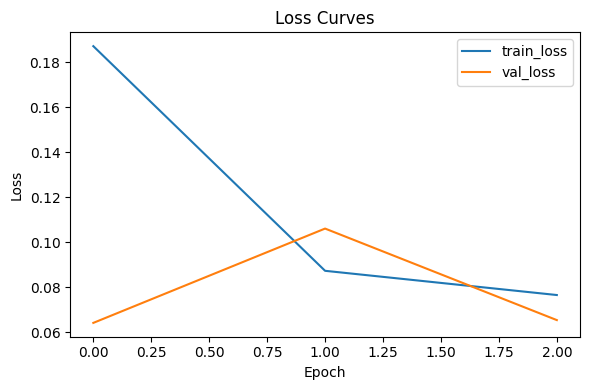

In [4]:
# Plot loss curves
from pioneerml.common.evaluation.plots.loss import LossCurvesPlot

if trained_module is None:
    raise RuntimeError("No trained module loaded from pipeline run.")

LossCurvesPlot().render(trained_module, show=True)
